In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import math

Define four planes with the form
$$ax+by+cz+d=0$$

In [2]:
#planesCoef = np.array([[0,0,1,0,0,5,0,5],[0,0,1,-0.2,5,10,0,5],[0,0,1,-0.5,0,5,5,10],[0,0,1,0,5,10,5,10]])
planesCoef = np.array([[0,0,1,0,0,5,0,5]])
    
    

# Optimization Model

$$
\min_{\mathbf{H},\mathbf{f}_{i,j},\Gamma} P\sum_{i,j}||\mathbf{f}_{i+1,j}-\mathbf{f}_{i,j}||
    +Q\sum_{i,j,r}H_{i,j,r}f^r_{\sigma}(x_{i,j},y_{i,j})K^{\gamma_{i,j}} 
    + R\sum_{i,j}\gamma_{i,j}
$$

the constraints are:

 $$\sum_{r=1}^RH_{i,j,r}=1 \\
    H_{i,j,r}=1 \implies f^r_e(x_{i,j},y_{i,j},z_{i,j})=0 \\
    ||\mathbf{f}_{i+1,j}-\mathbf{f}_{i,j}||_2 < \alpha_1 \\
    ||\mathbf{f}_{i,j}-\mathbf{f}_{i,k}||_2 < \alpha_2, j\neq k \\
    \mathbf{f}_{0,j} = \mathbf{f}_0 \\
    \mathbf{f}_{N,j} = \mathbf{f}_t \\
    1 \leqslant \gamma_{i,j} \leqslant \gamma_{max}$$

In [3]:
from gurobipy import *

In [4]:
model = Model('FootStep Planning')

Using license file /home/shuo/gurobi.lic
Academic license - for non-commercial use only


### Create variables of the position and orientation for each foothold

In [5]:
N = 100
steps = [i for i in range(N)]
footIds = ['LF','RF','LH','RH']
states = ["x","y","z","theta"]
footstepStatesUpperBounds = {}
footstepStatesLowerBounds = {}
# for step in steps:
#     for state in states:
#         if state == 'x' or state == 'y':
#             footstepStatesUpperBounds[step,state] = 10.
#             footstepStatesLowerBounds[step,state] = 0.
#         elif state == 'z':
#             footstepStatesUpperBounds[step,state] = 1.
#             footstepStatesLowerBounds[step,state] = 0.
#         else:
#             footstepStatesUpperBounds[step,state] = math.pi
#             footstepStatesLowerBounds[step,state] = -math.pi
                
footstepStates = model.addVars(steps,states,name="footstepStates")

### Create binary variables for each foothold / assign them on one plane

In [6]:
# R = 1
# planes = [i for i in range(1)]
# footstepAssignment = model.addVars(steps,name="footstepAssignment",vtype=GRB.BINARY)
# model.update()
# print(model)

### Create constraints

In [7]:
# model.addConstrs((quicksum(footstepAssignment[step,footId,plane] for plane in planes) == 1 for step in steps for footId in footIds),name='a')
# model.update()

In [8]:
# model.addConstrs(( (footstepAssignment[step,footId,plane]==1) >>
#                  (planesCoef[plane,0]*footstepStates[step,footId,'x']+
#                  planesCoef[plane,1]*footstepStates[step,footId,'y']+
#                  planesCoef[plane,2]*footstepStates[step,footId,'z']+
#                  planesCoef[plane,3] == 0) for step in steps for footId in footIds for plane in planes) ,name='onPlane')
# model.update()

In [9]:
constr0 = model.addConstrs(planesCoef[0,0]*footstepStates[step,"x"]+
                 planesCoef[0,1]*footstepStates[step,"y"]+
                 planesCoef[0,2]*footstepStates[step,"z"]+
                 planesCoef[0,3] == 0 for step in steps)

In [10]:
 maxDistanceBetweenSteps = 0.2
model.addConstrs((footstepStates[step,state]-footstepStates[step-1,state] <= maxDistanceBetweenSteps
                 for step in steps for state in states if step !=steps[0]),name="stepLimit")
model.addConstrs((footstepStates[step,state]-footstepStates[step-1,state] >= -maxDistanceBetweenSteps
                 for step in steps for state in states if step !=steps[0]),name="stepLimit")

{(1, 'x'): <gurobi.Constr *Awaiting Model Update*>,
 (1, 'y'): <gurobi.Constr *Awaiting Model Update*>,
 (1, 'z'): <gurobi.Constr *Awaiting Model Update*>,
 (1, 'theta'): <gurobi.Constr *Awaiting Model Update*>,
 (2, 'x'): <gurobi.Constr *Awaiting Model Update*>,
 (2, 'y'): <gurobi.Constr *Awaiting Model Update*>,
 (2, 'z'): <gurobi.Constr *Awaiting Model Update*>,
 (2, 'theta'): <gurobi.Constr *Awaiting Model Update*>,
 (3, 'x'): <gurobi.Constr *Awaiting Model Update*>,
 (3, 'y'): <gurobi.Constr *Awaiting Model Update*>,
 (3, 'z'): <gurobi.Constr *Awaiting Model Update*>,
 (3, 'theta'): <gurobi.Constr *Awaiting Model Update*>,
 (4, 'x'): <gurobi.Constr *Awaiting Model Update*>,
 (4, 'y'): <gurobi.Constr *Awaiting Model Update*>,
 (4, 'z'): <gurobi.Constr *Awaiting Model Update*>,
 (4, 'theta'): <gurobi.Constr *Awaiting Model Update*>,
 (5, 'x'): <gurobi.Constr *Awaiting Model Update*>,
 (5, 'y'): <gurobi.Constr *Awaiting Model Update*>,
 (5, 'z'): <gurobi.Constr *Awaiting Model Update

In [11]:
model.addConstrs(footstepStates[steps[0],state] <= maxDistanceBetweenSteps for state in states if state != states[-1])
model.addConstrs(footstepStates[steps[-1],state]-5.0 <= maxDistanceBetweenSteps for state in states if state != states[-1] and state != states[-2])
model.addConstrs(footstepStates[steps[-1],state]-5.0 >= -maxDistanceBetweenSteps for state in states if state != states[-1] and state != states[-2])
model.addConstr(footstepStates[steps[0],states[-1]] == 0.0)
model.addConstr(footstepStates[steps[-1],states[-1]] == 0.0)


<gurobi.Constr *Awaiting Model Update*>

In [12]:
obj = quicksum((footstepStates[step,states[0]]-footstepStates[step-1,states[0]])*
               (footstepStates[step,states[0]]-footstepStates[step-1,states[0]])+
              (footstepStates[step,states[1]]-footstepStates[step-1,states[1]])*
               (footstepStates[step,states[1]]-footstepStates[step-1,states[1]])
              for step in steps if step != steps[0])
model.setObjective(obj, GRB.MINIMIZE)

In [13]:
model.optimize()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 901 rows, 400 columns and 1693 nonzeros
Model fingerprint: 0xbc1f9fb1
Model has 398 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+00]
Presolve removed 608 rows and 104 columns
Presolve time: 0.01s
Presolved: 293 rows, 587 columns, 877 nonzeros
Presolved model has 398 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 198
 AA' NZ     : 1.528e+03
 Factor NZ  : 6.018e+03 (roughly 1 MByte of memory)
 Factor Ops : 9.205e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.07845248e-11 -1.17600000e+05  1.00e+03 2.45e-06  1.00e+06     0s
   1   2.03012269e+05 -3.30861103e+05  4.17e+

/home/shuo/anaconda3/envs/footholdPlanning/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


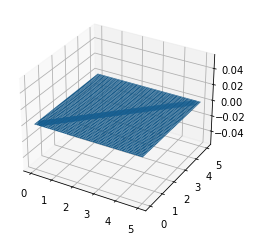

In [14]:
optimalFootstep = np.zeros((3,N))
solutions = model.getAttr('x', footstepStates)
#print(solutions)
for solu in solutions:
    if solu[1] == 'x':
        optimalFootstep[0,solu[0]] = solutions[solu]
    elif solu[1] == 'y':
        optimalFootstep[1,solu[0]] = solutions[solu]
    elif solu[1] == 'z':
        optimalFootstep[2,solu[0]] = solutions[solu]
#print(optimalFootstep)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.axis('auto')
for plane in range(planesCoef.shape[0]):
    x = np.linspace(planesCoef[plane,4],planesCoef[plane,5],100)
    y = np.linspace(planesCoef[plane,6],planesCoef[plane,7],100)
    X,Y = np.meshgrid(x,y)
    Z = ((-planesCoef[plane,0]*X-planesCoef[plane,1]*Y)-planesCoef[plane,3])/planesCoef[plane,2]
    surf = ax.plot_surface(X, Y, Z)
ax.scatter(optimalFootstep[0,:],optimalFootstep[1,:],optimalFootstep[2,:])
fig.show()
# for step in steps:
#    optimalFootstep[:,step] = np.array([footstepStates[step,"x"],footstepStates[step,"y"],footstepStates[step,"z"]]) 

